##  Bayesian model for the motion of 47 Ursae Majoris

Finding the orbital parameters (orbital period, eccentricity, velocity, etc.) of the first planet in this system, using data from table 1 of [Fischer et al 2002](http://iopscience.iop.org/article/10.1086/324336/meta).   

Data file: ``47UrsaeMajoris.txt``

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn; seaborn.set()

### Radial Velocity Model

In [2]:
from collections import namedtuple
params = namedtuple('params', ['T', 'e', 'K', 'V', 'omega', 'chi', 's'])

In [3]:
from scipy import optimize

@np.vectorize
def compute_E(M, e):
    """Solve Kepler's eqns for eccentric anomaly given mean anomaly"""
    f = lambda E, M=M, e=e: E - e * np.sin(E) - M
    return optimize.brentq(f, 0, 2 * np.pi)


def radial_velocity(t, theta):
    """Compute radial velocity given orbital parameters"""
    T, e, K, V, omega, chi = theta[:6]
    
    # compute mean anomaly (0 <= M < 2pi)
    M = 2 * np.pi * ((t / T + chi) % 1)
    
    # solve for eccentric anomaly
    E = compute_E(M, e)
    
    # compute true anomaly
    f = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2),
                       np.sqrt(1 - e) * np.cos(E / 2))
    
    # compute radial velocity
    return V - K * (np.sin(f + omega) + e * np.sin(omega))

### The Prior, Likelihood, and Posterior

In [4]:
theta_lim = params(T=(0.2, 2000),
                   e=(0, 1),
                   K=(0.01, 2000),
                   V=(-2000, 2000),
                   omega=(0, 2 * np.pi),
                   chi=(0, 1),
                   s=(0.001, 100))
theta_min, theta_max = map(np.array, zip(*theta_lim))

def log_prior(theta):
    if np.any(theta < theta_min) or np.any(theta > theta_max):
        return -np.inf # log(0)
    
    # Jeffreys Prior on T, K, and s
    return -np.sum(np.log(theta[[0, 2, 6]]))

def log_likelihood(theta, t, rv, rv_err):
    sq_err = rv_err ** 2 + theta[6] ** 2
    rv_model = radial_velocity(t, theta)
    return -0.5 * np.sum(np.log(sq_err) + (rv - rv_model) ** 2 / sq_err)

def log_posterior(theta, t, rv, rv_err):
    ln_prior = log_prior(theta)
    if np.isinf(ln_prior):
        return ln_prior
    else:
        return ln_prior + log_likelihood(theta, t, rv, rv_err)
    
def make_starting_guess(t, rv, rv_err):
    model = LombScargleFast()
    model.optimizer.set(period_range=theta_lim.T,
                        quiet=True)
    model.fit(t, rv, rv_err)

    rv_range = 0.5 * (np.max(rv) - np.min(rv))
    rv_center = np.mean(rv)
    return params(T=model.best_period,
                  e=0.1,
                  K=rv_range,
                  V=rv_center,
                  omega=np.pi,
                  chi=0.5,
                  s=rv_err.mean())

### The Data

In [5]:
import pandas as pd
data = pd.read_csv('47UrsaeMajoris.txt', delim_whitespace=True)
t, rv, rv_err = data.values.T

### Visualize the Data

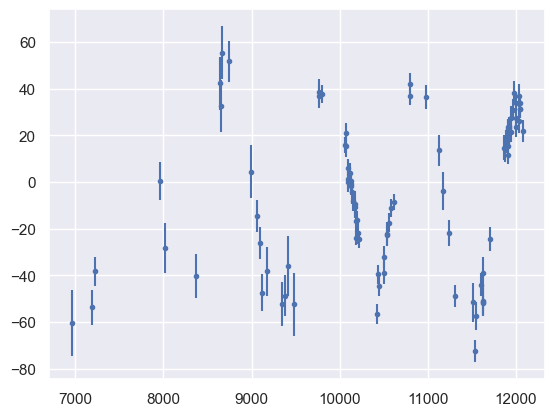

In [6]:
# Start by Visualizing the Data
plt.errorbar(t, rv, rv_err, fmt='.');

### Compute the Periodogram

/Users/orion/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':


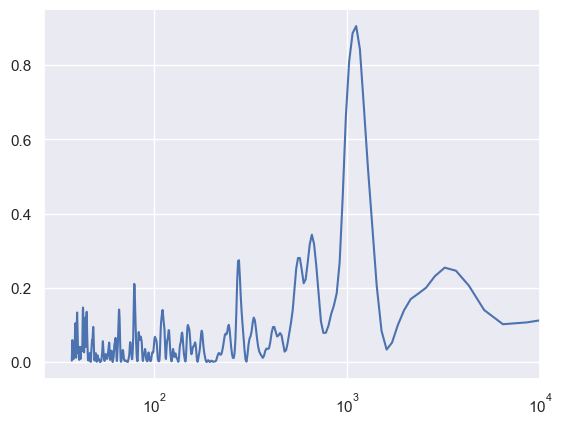

In [7]:
# Compute the periodogram to look for significant periodicity

from gatspy.periodic import LombScargleFast
model = LombScargleFast()

model.fit(t, rv, rv_err)
periods, power = model.periodogram_auto()
plt.semilogx(periods, power)
plt.xlim(0, 10000);

### Initialize and run the MCMC Chain

In [8]:
theta_guess = make_starting_guess(t, rv, rv_err)
theta_guess

params(T=1109.0856134459539, e=0.1, K=63.945, V=-4.4617582417582415, omega=3.141592653589793, chi=0.5, s=5.715164835164835)

In [9]:
import emcee

ndim = len(theta_guess)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers

# start with a tight distribution of theta around the initial guess
rng = np.random.RandomState(42)
starting_guesses = theta_guess * (1 + 0.1 * rng.randn(nwalkers, ndim))

# create the sampler; fix the random state for replicability
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t, rv, rv_err))
sampler.random_state = rng

# time and run the MCMC
%time pos, prob, state = sampler.run_mcmc(starting_guesses, 1000)

CPU times: user 28.7 s, sys: 271 ms, total: 29 s
Wall time: 29.2 s


### Plot the chains: have they stabilized?

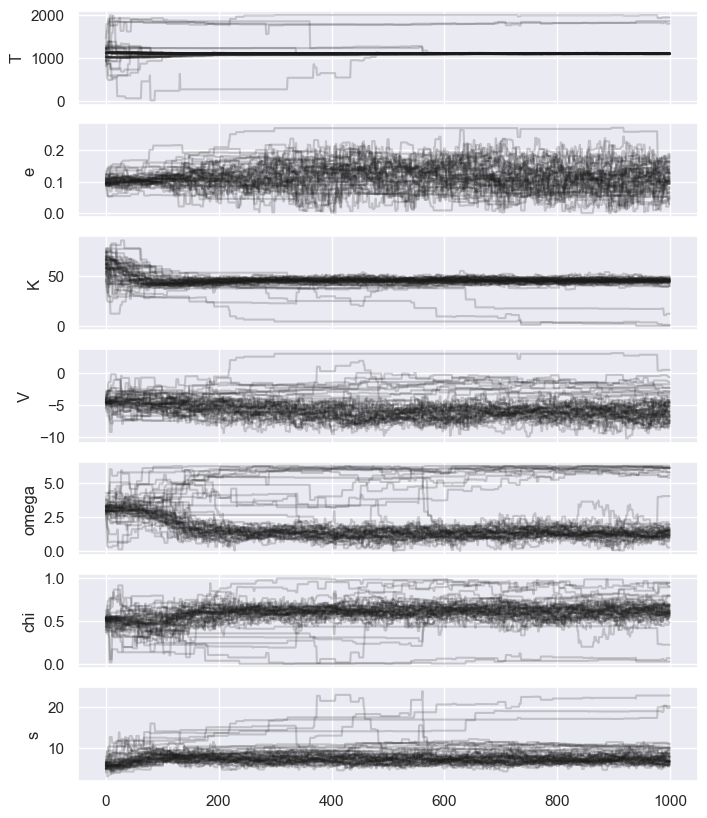

In [10]:
def plot_chains(sampler):
    fig, ax = plt.subplots(7, figsize=(8, 10), sharex=True)
    for i in range(7):
        ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);
        ax[i].set_ylabel(params._fields[i])

plot_chains(sampler)

In [11]:
sampler.reset()
%time pos, prob, state = sampler.run_mcmc(pos, 1000)

CPU times: user 28 s, sys: 270 ms, total: 28.3 s
Wall time: 28.5 s


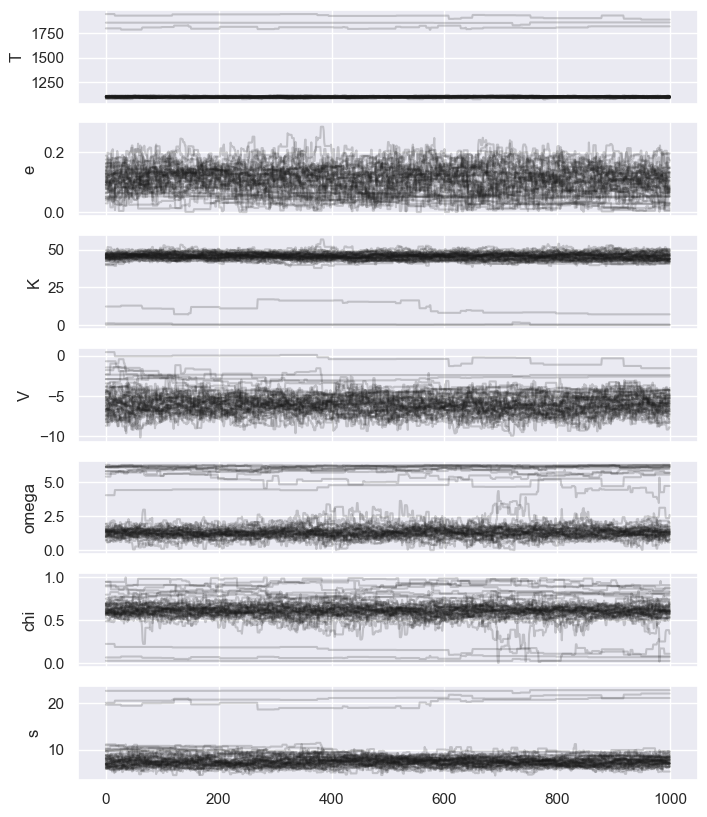

In [12]:
plot_chains(sampler)

### Make a Corner Plot for the Parameters

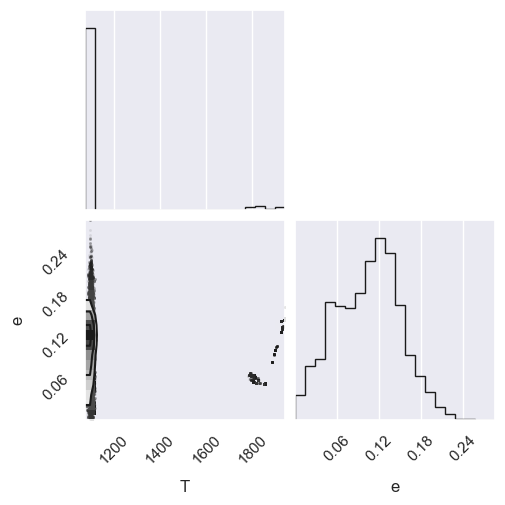

In [13]:
import corner
corner.corner(sampler.flatchain[:, :2], 
              labels=params._fields[:2]);

### Plot the Model Fits over the Data

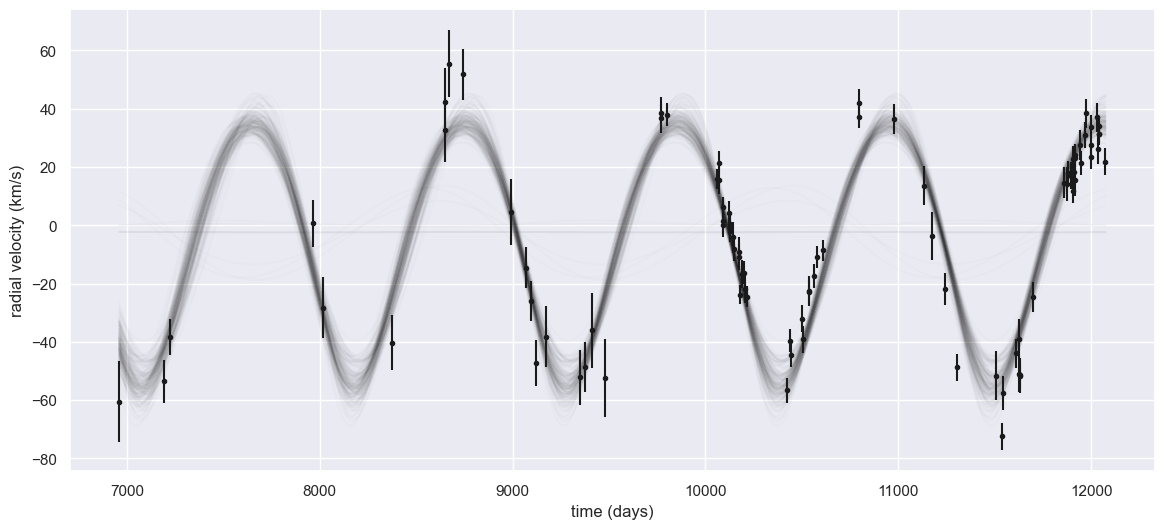

In [14]:
t_fit = np.linspace(t.min(), t.max(), 1000)
rv_fit = [radial_velocity(t_fit, sampler.flatchain[i])
          for i in rng.choice(sampler.flatchain.shape[0], 200)]

plt.figure(figsize=(14, 6))
plt.errorbar(t, rv, rv_err, fmt='.k')
plt.plot(t_fit, np.transpose(rv_fit), '-k', alpha=0.01)
plt.xlabel('time (days)')
plt.ylabel('radial velocity (km/s)');

### Results: Report your (joint) uncertainties on period and eccentricity

In [15]:
mean = sampler.flatchain.mean(0)
std = sampler.flatchain.std(0)

print("Period       = {0:.0f} +/- {1:.0f} days".format(mean[0], std[0]))
print("eccentricity = {0:.2f} +/- {1:.2f}".format(mean[1], std[1]))

Period       = 1147 +/- 181 days
eccentricity = 0.10 +/- 0.05


In this case, a simple mean and standard deviation is probably not the best summary of the data, because the posterior has multiple modes. We could isolate the strongest mode and then get a better estimate:

Period       = 1147 +/- 181 days
eccentricity = 0.10 +/- 0.05


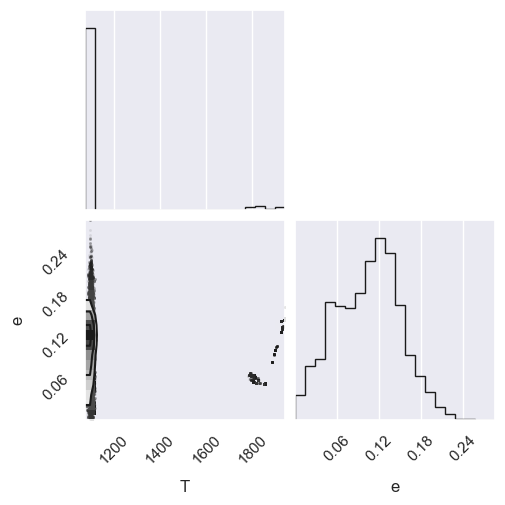

In [16]:
chain = sampler.flatchain[sampler.flatchain[:, 0] > 1050]
mean = chain.mean(0)
std = chain.std(0)

print("Period       = {0:.0f} +/- {1:.0f} days".format(mean[0], std[0]))
print("eccentricity = {0:.2f} +/- {1:.2f}".format(mean[1], std[1]))
corner.corner(chain[:, :2], 
              labels=params._fields[:2]);